In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano

from scipy.integrate import odeint
from theano import *

THEANO_FLAGS = "optimizer=fast_compile"

In [4]:
class LotkaVolterraModel:
    def __init__(self, y0=None):
        self._y0 = y0

    def simulate(self, parameters, times):
        alpha, beta, gamma, delta, Xt0, Yt0 = [x for x in parameters]

        def rhs(y, t, p):
            X, Y = y
            dX_dt = alpha * X - beta * X * Y
            dY_dt = -gamma * Y + delta * X * Y
            return dX_dt, dY_dt

        values = odeint(rhs, [Xt0, Yt0], times, (parameters,))
        return values


ode_model = LotkaVolterraModel()

In [5]:
n_states = 2
n_odeparams = 4
n_ivs = 2


class LotkaVolterraModel:
    def __init__(self, n_states, n_odeparams, n_ivs, y0=None):
        self._n_states = n_states
        self._n_odeparams = n_odeparams
        self._n_ivs = n_ivs
        self._y0 = y0

    def simulate(self, parameters, times):
        return self._simulate(parameters, times, False)

    def simulate_with_sensitivities(self, parameters, times):
        return self._simulate(parameters, times, True)

    def _simulate(self, parameters, times, sensitivities):
        alpha, beta, gamma, delta, Xt0, Yt0 = [x for x in parameters]

        def r(y, t, p):
            X, Y = y
            dX_dt = alpha * X - beta * X * Y
            dY_dt = -gamma * Y + delta * X * Y
            return dX_dt, dY_dt

        if sensitivities:

            def jac(y):
                X, Y = y
                ret = np.zeros((self._n_states, self._n_states))
                ret[0, 0] = alpha - beta * Y
                ret[0, 1] = -beta * X
                ret[1, 0] = delta * Y
                ret[1, 1] = -gamma + delta * X
                return ret

            def dfdp(y):
                X, Y = y
                ret = np.zeros(
                    (self._n_states, self._n_odeparams + self._n_ivs)
                )  # except the following entries
                ret[
                    0, 0
                ] = X  # \frac{\partial  [\alpha X - \beta XY]}{\partial \alpha}, and so on...
                ret[0, 1] = -X * Y
                ret[1, 2] = -Y
                ret[1, 3] = X * Y

                return ret

            def rhs(y_and_dydp, t, p):
                y = y_and_dydp[0 : self._n_states]
                dydp = y_and_dydp[self._n_states :].reshape(
                    (self._n_states, self._n_odeparams + self._n_ivs)
                )
                dydt = r(y, t, p)
                d_dydp_dt = np.matmul(jac(y), dydp) + dfdp(y)
                return np.concatenate((dydt, d_dydp_dt.reshape(-1)))

            y0 = np.zeros((2 * (n_odeparams + n_ivs)) + n_states)
            y0[6] = 1.0  # \frac{\partial  [X]}{\partial Xt0} at t==0, and same below for Y
            y0[13] = 1.0
            y0[0:n_states] = [Xt0, Yt0]
            result = odeint(rhs, y0, times, (parameters,), rtol=1e-6, atol=1e-5)
            values = result[:, 0 : self._n_states]
            dvalues_dp = result[:, self._n_states :].reshape(
                (len(times), self._n_states, self._n_odeparams + self._n_ivs)
            )
            return values, dvalues_dp
        else:
            values = odeint(r, [Xt0, Yt0], times, (parameters,), rtol=1e-6, atol=1e-5)
            return values


ode_model = LotkaVolterraModel(n_states, n_odeparams, n_ivs)

In [6]:
class ODEGradop(theano.Op):
    def __init__(self, numpy_vsp):
        self._numpy_vsp = numpy_vsp

    def make_node(self, x, g):
        x = theano.tensor.as_tensor_variable(x)
        g = theano.tensor.as_tensor_variable(g)
        node = theano.Apply(self, [x, g], [g.type()])
        return node

    def perform(self, node, inputs_storage, output_storage):
        x = inputs_storage[0]

        g = inputs_storage[1]
        out = output_storage[0]
        out[0] = self._numpy_vsp(x, g)  # get the numerical VSP


class ODEop(theano.Op):
    def __init__(self, state, numpy_vsp):
        self._state = state
        self._numpy_vsp = numpy_vsp

    def make_node(self, x):
        x = theano.tensor.as_tensor_variable(x)

        return theano.Apply(self, [x], [x.type()])

    def perform(self, node, inputs_storage, output_storage):
        x = inputs_storage[0]
        out = output_storage[0]

        out[0] = self._state(x)  # get the numerical solution of ODE states

    def grad(self, inputs, output_grads):
        x = inputs[0]
        g = output_grads[0]

        grad_op = ODEGradop(self._numpy_vsp)  # pass the VSP when asked for gradient
        grad_op_apply = grad_op(x, g)

        return [grad_op_apply]

In [21]:
class solveCached:
    def __init__(self, times, n_params, n_outputs):

        self._times = times
        self._n_params = n_params
        self._n_outputs = n_outputs
        self._cachedParam = np.zeros(n_params)
        self._cachedSens = np.zeros((len(times), n_outputs, n_params))
        self._cachedState = np.zeros((len(times), n_outputs))

    def __call__(self, x):

        if np.all(x == self._cachedParam):
            state, sens = self._cachedState, self._cachedSens

        else:
            state, sens = ode_model.simulate_with_sensitivities(x, times)

        return state, sens


times = np.arange(0, 16001)  # number of measurement points (see below)
cached_solver = solveCached(times, n_odeparams + n_ivs, n_states)

In [22]:
def state(x):
    State, Sens = cached_solver(np.array(x, dtype=np.float64))
    cached_solver._cachedState, cached_solver._cachedSens, cached_solver._cachedParam = (
        State,
        Sens,
        x,
    )
    return State.reshape((2 * len(State),))


def numpy_vsp(x, g):
    numpy_sens = cached_solver(np.array(x, dtype=np.float64))[1].reshape(
        (n_states * len(times), len(x))
    )
    return numpy_sens.T.dot(g)

In [23]:
# Definition of the Lotka-Volterra model, with VP = f(x(t), t; theta)
def VP(z, t, alpha, beta, gamma, sigma):
    x, y = z
    dzdt = [alpha * x - beta * x * y, - gamma * y + sigma * x*y]
    return dzdt

In [24]:
# Data of the problem
data_size = 16001  # Size of the dataset (fictitious and created by adding noise to the real
                   #  data found through the integration of the system)
batch_time = 320  #
niters = 1000  # Number of Hamiltonian MC iterations
batch_size = 1000

# Parameters of the true model
alpha = 1.
beta = 0.1
gamma = 1.5
sigma = 0.75

In [25]:
t_grid = np.linspace(0, 25, data_size)
z0 = [5., 5.]
true_yy = odeint(VP, z0, t_grid, args=(alpha, beta, gamma, sigma))

In [26]:
true_y = true_yy.copy()

sigma_x = np.std(true_yy[:, 0:1])  # Standard deviation of data for x = preys
sigma_y = np.std(true_yy[:, 1:2])  # Standard deviation of data for y = predators

noise_level = 0.03  # Adding some nois with this noise level
sigma_normal = max(sigma_x, sigma_y)  # Considering the highest between the 2

true_y[:, 0:1] = true_y[:, 0:1]/sigma_x + noise_level * np.random.randn(true_y[:, 0:1].shape[0], true_y[:, 0:1].shape[1])
true_y[:, 1:2] = true_y[:, 1:2]/sigma_y + noise_level * np.random.randn(true_y[:, 1:2].shape[0], true_y[:, 1:2].shape[1])
# The 2 lines above normalize the data and then add a noise being extract from a gaussian
#  random variable with 0 mean and (noise_level)^2 variance.

In [34]:
import os
# one of
os.environ['MKL_THREADING_LAYER'] = 'sequential'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_THREADING_LAYER'] = 'GNU'

In [39]:
theano.config.exception_verbosity = "high"
theano.config.floatX = "float64"


# Define the data matrix
Y = true_y

# Now instantiate the theano custom ODE op
my_ODEop = ODEop(state, numpy_vsp)

# The probabilistic model
with pm.Model() as LV_model:

    # Priors for unknown model parameters

    alpha = pm.Normal("alpha", mu=0, sd=1)
    beta = pm.Normal("beta", mu=0, sd=1)
    gamma = pm.Normal("gamma", mu=0, sd=1)
    delta = pm.Normal("delta", mu=0, sd=1)

    xt0 = 2.91830171
    yt0 =  0.49217373
    sigma = pm.Lognormal("sigma", mu=-1, sd=1, shape=2)

    # Forward model
    all_params = pm.math.stack([alpha, beta, gamma, delta, xt0, yt0], axis=0)
    ode_sol = my_ODEop(all_params)
    forward = ode_sol.reshape(Y.shape)

    # Likelihood
    Y_obs = pm.Lognormal("Y_obs", mu=pm.math.log(forward), sd=sigma, observed=Y)

    trace = pm.sample(700, tune=100, init="adapt_diag", chains = 1)
trace["diverging"].sum()

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, delta, gamma, beta, alpha]


C:\Users\ffede\Tf\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
Sampling 1 chain for 100 tune and 700 draw iterations (100 + 700 draws total) took 8986 seconds.
There were 279 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5636517440164189, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


279

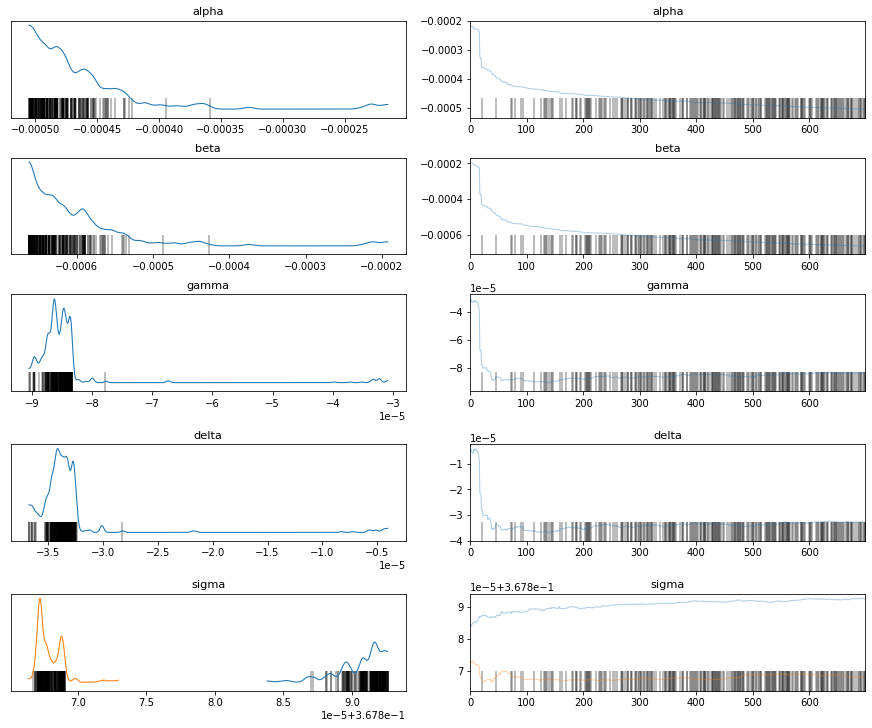

In [40]:
with LV_model:
    pm.traceplot(trace);